In [17]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score, recall_score, f1_score
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import seaborn as sns
import torch.nn.functional as F
import pandas as pd 

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(model_class, model_path):
    model = model_class().to(device) 
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

class AutismDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.filepaths = []
        self.labels = []

        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                label = 0 if category == 'TC' else 1
                for participant_folder in os.listdir(category_path):
                    participant_path = os.path.join(category_path, participant_folder)
                    if os.path.isdir(participant_path):
                        for img_name in os.listdir(participant_path):
                            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                                img_full_path = os.path.join(participant_path, img_name)
                                self.filepaths.append(img_full_path)
                                self.labels.append(label)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    num_samples = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        num_samples += batch_samples

    if num_samples == 0:
        raise ValueError("Dataset is empty. Ensure your data loader is correctly configured.")

    mean /= num_samples
    std /= num_samples
    return mean, std

In [19]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(16)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.batch_norm4 = nn.BatchNorm2d(32)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.leaky_relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x).squeeze()
        return x

In [20]:
class DenseModel(nn.Module):
    def __init__(self):
        super(DenseModel, self).__init__()
        self.model = models.densenet121(pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        for param in self.model.features.denseblock4.parameters():
            param.requires_grad = True

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
        self.model.classifier.apply(self.initialize_weights)

    def forward(self, x):
        output = self.model(x)
        if self.model.classifier[-1].out_features == 1:
            output = torch.sigmoid(output)
        return output

    @staticmethod
    def initialize_weights(layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

In [21]:
class ResModel(nn.Module):
    def __init__(self):
        super(ResModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
        self.model.fc.apply(self.initialize_weights)

    def forward(self, x):
        output = self.model(x)
        if self.model.fc[-1].out_features == 1:
            output = torch.sigmoid(output)
        return output

    @staticmethod
    def initialize_weights(layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

In [22]:
class VGGModel(nn.Module):
    def __init__(self):
        super(VGGModel, self).__init__()
        self.model = models.vgg19(pretrained=True)
        
        for param in self.model.features.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[0].in_features
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
        self.model.classifier.apply(self.initialize_weights)

    def forward(self, x):
        output = self.model(x)
        if self.model.classifier[-1].out_features == 1:
            output = torch.sigmoid(output)
        return output

    @staticmethod
    def initialize_weights(layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

In [23]:
train_path = "./Dataset_Split4/Augmented_Train"
test_path = "./Dataset_Split4/Test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = AutismDataset(train_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

train_mean, train_std = calculate_mean_std(train_loader)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

test_dataset = AutismDataset(test_path, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [24]:
models_dict = {
    "ResNet50": {"class": ResModel, "path": "./best_model_res.pth"},
    "DenseNet": {"class": DenseModel, "path": "./best_model_dense.pth"},
    "VGG19": {"class": VGGModel, "path": "./best_model_vgg.pth"},
    "CNN": {"class": CNNModel, "path": "./best_model_cnn.pth"},
}

In [25]:
roc_data = {}
prc_data = {}
confusion_matrices = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model_name, model_info in models_dict.items():
    model_class = model_info["class"]
    model_path = model_info["path"]
    
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    test_preds, test_true = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device, dtype=torch.float32).view(-1)
            outputs = model(inputs).squeeze()
            test_preds.extend(outputs.cpu().numpy())
            test_true.extend(labels.cpu().numpy())
    
    fpr, tpr, _ = roc_curve(test_true, test_preds)
    roc_auc = auc(fpr, tpr)
    roc_data[model_name] = {"fpr": fpr, "tpr": tpr, "auc": roc_auc}
    
    precision, recall, _ = precision_recall_curve(test_true, test_preds)
    avg_precision = average_precision_score(test_true, test_preds)
    prc_data[model_name] = {"precision": precision, "recall": recall, "avg_precision": avg_precision}
    
    preds_binary = [1 if p >= 0.5 else 0 for p in test_preds]  
    cm = confusion_matrix(test_true, preds_binary)
    confusion_matrices[model_name] = cm
    
    print(f"Model: {model_name}, ROC AUC: {roc_auc}, Average Precision: {avg_precision}, recall: {recall_score(test_true, preds_binary)}, f1: {f1_score(test_true, preds_binary)}")

/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_768418/4020342582.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/

Model: ResNet50, ROC AUC: 0.8465674110835402, Average Precision: 0.8068886732093321, recall: 0.5897435897435898, f1: 0.6764705882352942


/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_768418/4020342582.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

Model: DenseNet, ROC AUC: 0.8341604631927212, Average Precision: 0.7937414822193118, recall: 0.6923076923076923, f1: 0.72


/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_768418/4020342582.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/S

Model: VGG19, ROC AUC: 0.8023159636062862, Average Precision: 0.8018957098410874, recall: 0.717948717948718, f1: 0.6666666666666666


/tmp/ipykernel_768418/4020342582.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model: CNN, ROC AUC: 0.8345740281224152, Average Precision: 0.7964847738946759, recall: 0.3333333333333333, f1: 0.49056603773584906


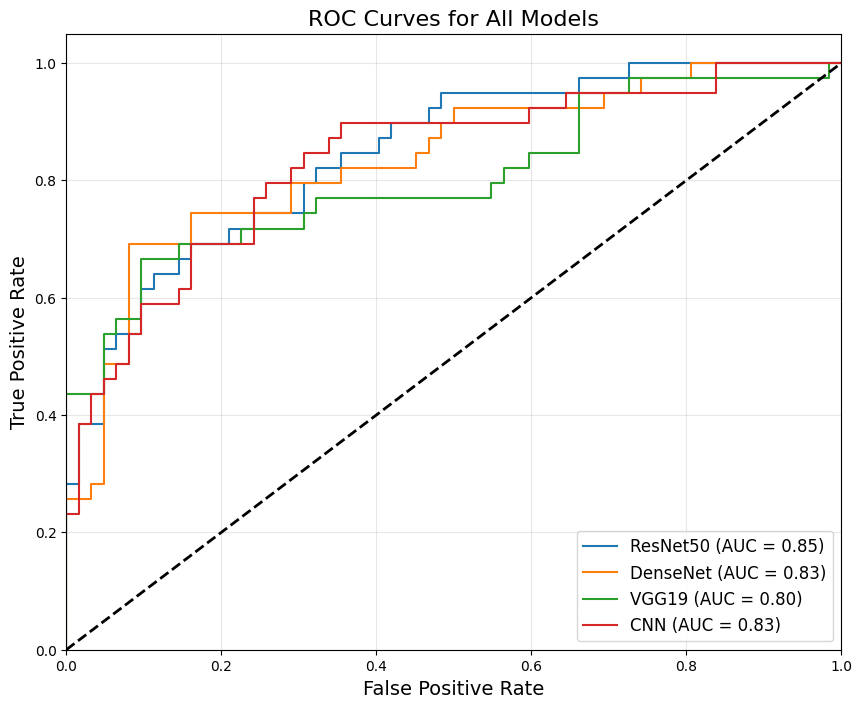

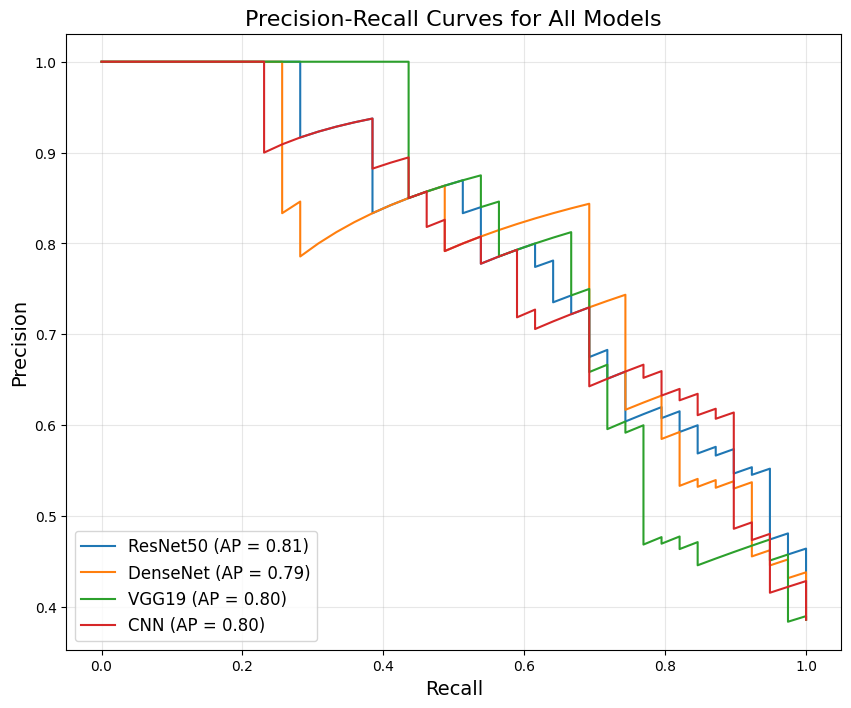

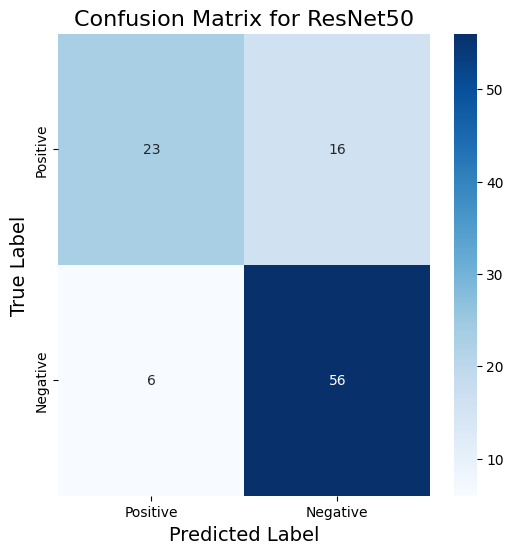

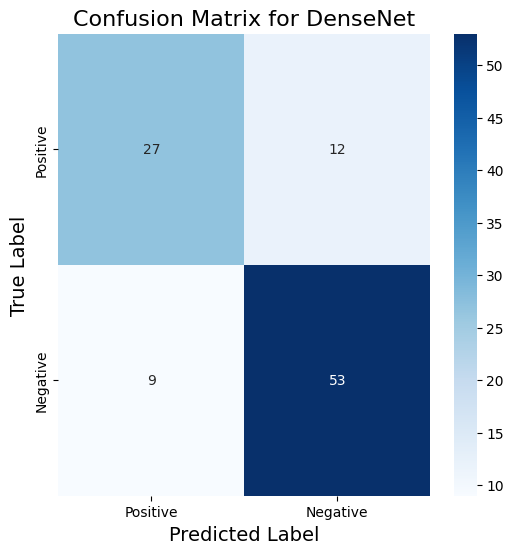

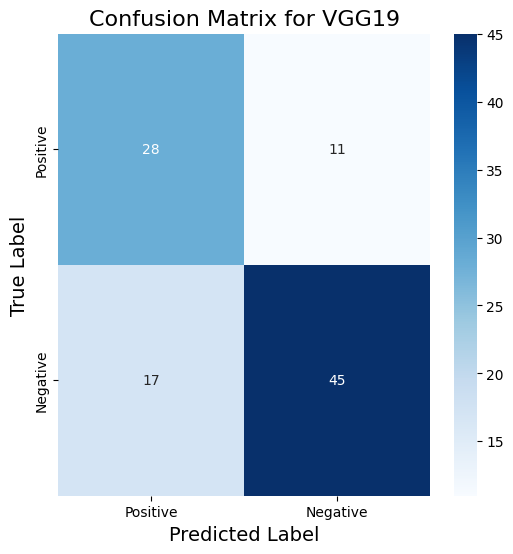

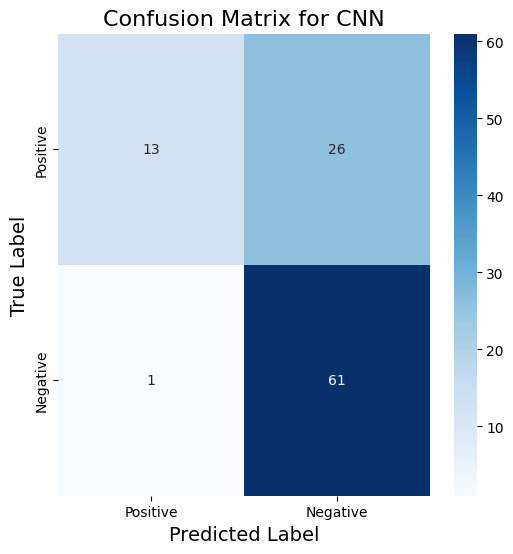

In [26]:
plt.figure(figsize=(10, 8))
for model_name, data in roc_data.items():
    plt.plot(data["fpr"], data["tpr"], label=f'{model_name} (AUC = {data["auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for All Models', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 8))
for model_name, data in prc_data.items():
    plt.plot(data["recall"], data["precision"], label=f'{model_name} (AP = {data["avg_precision"]:.2f})')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves for All Models', fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

for model_name, cm in confusion_matrices.items():
    reordered_cm = cm[[1, 0], :] 
    reordered_cm = reordered_cm[:, [1, 0]] 
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        reordered_cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=['Positive', 'Negative'],  
        yticklabels=['Positive', 'Negative'] )
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.show()


In [40]:
class AutismDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        for category in os.listdir(root_dir):
            category_dir = os.path.join(root_dir, category)
            if os.path.isdir(category_dir):
                for participant_folder in os.listdir(category_dir):
                    participant_path = os.path.join(category_dir, participant_folder)
                    if os.path.isdir(participant_path):
                        image_paths = []
                        for img_name in os.listdir(participant_path):
                            if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                                img_full_path = os.path.join(participant_path, img_name)
                                if os.path.isfile(img_full_path):
                                    image_paths.append(img_full_path)
                        if image_paths:
                            self.data.append(image_paths)
                            label = 0 if category == 'TC' else 1
                            self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        images = self.data[idx]
        label = self.labels[idx]
        processed_images = [self.transform(Image.open(img).convert("RGB")) for img in images]
        return torch.stack(processed_images), label
    
    
def collate_fn(batch):
    images, labels = zip(*batch)
    lengths = [img_seq.size(0) for img_seq in images]
    c, h, w = images[0].size(-3), images[0].size(-2), images[0].size(-1)
    max_seq_len = max(lengths)
    padded_images = torch.zeros(len(images), max_seq_len, c, h, w)

    for i, img_seq in enumerate(images):
        padded_images[i, :len(img_seq)] = img_seq

    return padded_images, lengths, torch.tensor(labels)


test_dir = "./Dataset_Split4/Test"

test_dataset = AutismDataset(test_dir, transform)

test_loader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

results={}

In [41]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)
        features = features.view(features.size(0), -1)
        return features

class TransformerSequenceModel(nn.Module):
    def __init__(self, feature_dim, hidden_dim, num_layers, num_heads, dropout=0.5):
        super(TransformerSequenceModel, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.input_proj = nn.Linear(feature_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, 
            nhead=num_heads, 
            dim_feedforward=hidden_dim * 4, 
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, lengths):
        x = self.input_proj(x)
        max_len = x.size(1)
        mask = torch.arange(max_len, device=x.device).expand(len(lengths), max_len) >= torch.tensor(lengths, device=x.device).unsqueeze(1)
        transformer_output = self.transformer(x, src_key_padding_mask=mask)
        pooled_output = torch.mean(transformer_output, dim=1)
        output = self.fc(pooled_output)
        return output.view(-1)

    
class AutismPredictionModel(nn.Module):
    def __init__(self, cnn, feature_dim, hidden_dim, num_layers, num_heads, dropout=0.5):
        super(AutismPredictionModel, self).__init__()
        self.cnn = cnn
        self.sequence_model = TransformerSequenceModel(
            feature_dim=feature_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            dropout=dropout
        )

    def forward(self, image_sequences, lengths):
        batch_size, seq_len, c, h, w = image_sequences.size()
        image_sequences = image_sequences.view(batch_size * seq_len, c, h, w)
        features = self.cnn(image_sequences)
        feature_dim = features.size(1)
        features = features.view(batch_size, seq_len, feature_dim)
        output = self.sequence_model(features, lengths)
        return output

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = CNNFeatureExtractor().to(device)
model = AutismPredictionModel(cnn, feature_dim=2048, hidden_dim=128, num_heads=32,num_layers=2).to(device)
model.load_state_dict(torch.load("./best_model_trans.pth"))  
model.eval()

all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for images, lengths, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images, lengths)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

recall = recall_score(all_labels, all_preds)
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

precision, recall_pr, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall_pr, precision)

conf_matrix = confusion_matrix(all_labels, all_preds)

results["transformers"] = {
    "roc": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": roc_thresholds.tolist(),
        "roc_auc": roc_auc
    },
    "prc": {
        "precision": precision.tolist(),
        "recall": recall_pr.tolist(),
        "thresholds": pr_thresholds.tolist(),
        "pr_auc": pr_auc
    },
    "confusion_matrix": conf_matrix.tolist(),
    "recall_score": recall
}

print(f"ROC AUC: {roc_auc}, Average Precision: {pr_auc}, recall: {recall}, f1: {f1_score(all_labels, all_preds)}")

/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_768418/3907784564.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/

ROC AUC: 0.9500000000000001, Average Precision: 0.94375, recall: 1.0, f1: 0.8888888888888888


In [42]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False  

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)
        features = features.view(features.size(0), -1)
        return features

class SequenceModelWithAttention(nn.Module):
    def __init__(self, feature_dim, hidden_dim, num_layers):
        super(SequenceModelWithAttention, self).__init__()
        self.lstm = nn.LSTM(feature_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.attention_layer = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x, lengths):
        if not isinstance(lengths, torch.Tensor):
            lengths = torch.tensor(lengths, dtype=torch.long, device='cpu')

        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        attention_scores = self.attention_layer(output).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=1)
        context_vector = torch.sum(output * attention_weights.unsqueeze(-1), dim=1)
        output = self.fc(context_vector)
        return output.view(-1)

    
class AutismPredictionModel(nn.Module):
    def __init__(self, cnn, feature_dim, hidden_dim, num_layers):
        super(AutismPredictionModel, self).__init__()
        self.cnn = cnn
        self.sequence_model = SequenceModelWithAttention(feature_dim, hidden_dim, num_layers)

    def forward(self, image_sequences, lengths):
        batch_size, seq_len, c, h, w = image_sequences.size()
        image_sequences = image_sequences.view(batch_size * seq_len, c, h, w)
        features = self.cnn(image_sequences)
        feature_dim = features.size(1)
        features = features.view(batch_size, seq_len, feature_dim)
        output = self.sequence_model(features, lengths)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = CNNFeatureExtractor().to(device)
model = AutismPredictionModel(cnn, feature_dim=2048, hidden_dim=256, num_layers=2).to(device)
model.load_state_dict(torch.load("./best_model_attention.pth"))  
model.eval()

all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for images, lengths, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images, lengths)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

recall = recall_score(all_labels, all_preds)
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

precision, recall_pr, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall_pr, precision)

conf_matrix = confusion_matrix(all_labels, all_preds)

results["lstm_attention"] = {
    "roc": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": roc_thresholds.tolist(),
        "roc_auc": roc_auc
    },
    "prc": {
        "precision": precision.tolist(),
        "recall": recall_pr.tolist(),
        "thresholds": pr_thresholds.tolist(),
        "pr_auc": pr_auc
    },
    "confusion_matrix": conf_matrix.tolist(),
    "recall_score": recall
}
print(f"ROC AUC: {roc_auc}, Average Precision: {pr_auc}, recall: {recall}, f1: {f1_score(all_labels, all_preds)}")

/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_768418/2262406109.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/

ROC AUC: 1.0, Average Precision: 1.0, recall: 1.0, f1: 0.8


In [43]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False  

    def forward(self, x):
        with torch.no_grad():
            features = self.resnet(x)
        features = features.view(features.size(0), -1) 
        return features

class SequenceModel(nn.Module):
    def __init__(self, feature_dim, hidden_dim, num_layers):
        super(SequenceModel, self).__init__()
        self.lstm = nn.LSTM(feature_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x, lengths):
        if not isinstance(lengths, torch.Tensor):
            lengths = torch.tensor(lengths, dtype=torch.long, device='cpu')

        packed_input = nn.utils.rnn.pack_padded_sequence(x, lengths.to('cpu'), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_input)
        
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)

        output = self.fc(hidden)
        return output.view(-1)
    
class AutismPredictionModel(nn.Module):
    def __init__(self, cnn, feature_dim, hidden_dim, num_layers):
        super(AutismPredictionModel, self).__init__()
        self.cnn = cnn
        self.sequence_model = SequenceModel(feature_dim, hidden_dim, num_layers)

    def forward(self, image_sequences, lengths):
        batch_size, seq_len, c, h, w = image_sequences.size()
        image_sequences = image_sequences.view(batch_size * seq_len, c, h, w)
        features = self.cnn(image_sequences)
        feature_dim = features.size(1)
        features = features.view(batch_size, seq_len, feature_dim)
        output = self.sequence_model(features, lengths)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = CNNFeatureExtractor().to(device)
model = AutismPredictionModel(cnn, feature_dim=2048, hidden_dim=256, num_layers=2).to(device)

model.load_state_dict(torch.load("./best_model_lstm.pth"))  
model.eval()

all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for images, lengths, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images, lengths)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

recall = recall_score(all_labels, all_preds)
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

precision, recall_pr, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall_pr, precision)

conf_matrix = confusion_matrix(all_labels, all_preds)

results["lstm"] = {
    "roc": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": roc_thresholds.tolist(),
        "roc_auc": roc_auc
    },
    "prc": {
        "precision": precision.tolist(),
        "recall": recall_pr.tolist(),
        "thresholds": pr_thresholds.tolist(),
        "pr_auc": pr_auc
    },
    "confusion_matrix": conf_matrix.tolist(),
    "recall_score": recall
}

print(f"ROC AUC: {roc_auc}, Average Precision: {pr_auc}, recall: {recall}, f1: {f1_score(all_labels, all_preds)}")

/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_768418/1365115161.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/

ROC AUC: 1.0, Average Precision: 1.0, recall: 1.0, f1: 0.8


In [44]:
class AutismDataset1(Dataset):
    def __init__(self, root_dir, type='ind', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.type = type    
        self.data = []
        self.images_all = []
        self.labels_all = []
        self.labels = []
        self.participant_id = []
        for category in os.listdir(root_dir):
            category_dir = os.path.join(root_dir, category)
            if os.path.isdir(category_dir):
                for participant_folder in os.listdir(category_dir):
                    participant_path = os.path.join(category_dir, participant_folder)
                    if os.path.isdir(participant_path):
                        image_paths = []
                        for img_name in os.listdir(participant_path):
                            if img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                                img_full_path = os.path.join(participant_path, img_name)
                                if os.path.isfile(img_full_path):
                                    image_paths.append(img_full_path)
                                    self.images_all.append(img_full_path)
                                    self.labels_all.append(0 if category == 'TC' else 1)
                        if image_paths:
                            self.data.append(image_paths)
                            label = 0 if category == 'TC' else 1
                            self.labels.append(label)
                            self.participant_id.append(participant_folder)

    def __len__(self):
        if self.type == 'img':
            return len(self.images_all)
        elif self.type == 'ind':
            return len(self.data)
    
    def __getitem__(self, idx):
        if self.type == 'img':
            image = self.images_all[idx]
            processed_image = self.transform(Image.open(image).convert("RGB"))
            label = self.labels_all[idx]
            return processed_image, label
        elif self.type == 'ind':
            images = self.data[idx]
            label = self.labels[idx]
            processed_images = [self.transform(Image.open(img).convert("RGB")) for img in images]
            return torch.stack(processed_images), label, self.participant_id[idx]
    
test_dataset = AutismDataset1(test_dir, type='ind', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
        self.model.fc.apply(self.initialize_weights)

    def forward(self, x):
        output = self.model(x)
        if self.model.fc[-1].out_features == 1:
            output = torch.sigmoid(output)
        return output

    @staticmethod
    def initialize_weights(layer):
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)
                
model = CNNModel().to(device)
model.load_state_dict(torch.load("best_model_vote.pth"))
model.eval()

all_labels = []
all_probs = []
all_preds = []

with torch.no_grad():
    for images, labels, participant_ids in test_loader:
        for i, participant_images in enumerate(images):
            participant_id = participant_ids[i]
            lbl = labels[i].item()
            preds = []
            probs = []

            for img in participant_images:
                img = img.unsqueeze(0).to(device)
                output = model(img)
                prob = torch.sigmoid(output).item()
                pred = (output > 0.5).float().item()
                probs.append(prob)
                preds.append(pred)

            all_labels.append(lbl)
            all_probs.append(np.mean(probs)) 
            all_preds.append(1 if np.mean(probs) > 0.5 else 0) 

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)

recall = recall_score(all_labels, all_preds)
fpr, tpr, roc_thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

precision, recall_pr, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall_pr, precision)


individual_results = []

with torch.no_grad():
    for images, labels, participant_ids in test_loader:
        labels = labels.to(device)
        for i, participant_images in enumerate(images):
            participant_id = participant_ids[i]
            lbl = labels[i].item()
            preds = []

            for img in participant_images:
                img = img.unsqueeze(0).to(device)
                output = model(img)
                pred = (output > 0.5).int().item()
                preds.append(pred)

            positive_preds = sum(preds)
            total_images = len(preds)
            individual_accuracy = positive_preds / total_images
            prediction = 1 if individual_accuracy > 0.5 else 0

            individual_results.append({
                 "Category": "TS" if lbl == 1 else "TC",
                "Participant": participant_id,
                "Prediction": "Autistic" if prediction == 1 else "Not Autistic",
                "Probability": individual_accuracy
            })


results_df = pd.DataFrame(individual_results)

true_labels = results_df['Category'].apply(lambda x: 1 if x == "TS" else 0).values
predicted_labels = results_df['Prediction'].apply(lambda x: 1 if x == "Autistic" else 0).values

cm = confusion_matrix(true_labels, predicted_labels)

results["vote"] = {
    "roc": {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "thresholds": roc_thresholds.tolist(),
        "roc_auc": roc_auc
    },
    "prc": {
        "precision": precision.tolist(),
        "recall": recall_pr.tolist(),
        "thresholds": pr_thresholds.tolist(),
        "pr_auc": pr_auc
    },
    "confusion_matrix": cm.tolist(),
    "recall_score": recall
}
print(f"ROC AUC: {roc_auc}, Average Precision: {pr_auc}, recall: {recall}, f1: {f1_score(all_labels, all_preds)}")

/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suhas99/ENPM703/Final/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_768418/2894941584.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/

ROC AUC: 0.9, Average Precision: 0.8708333333333333, recall: 1.0, f1: 0.6153846153846154


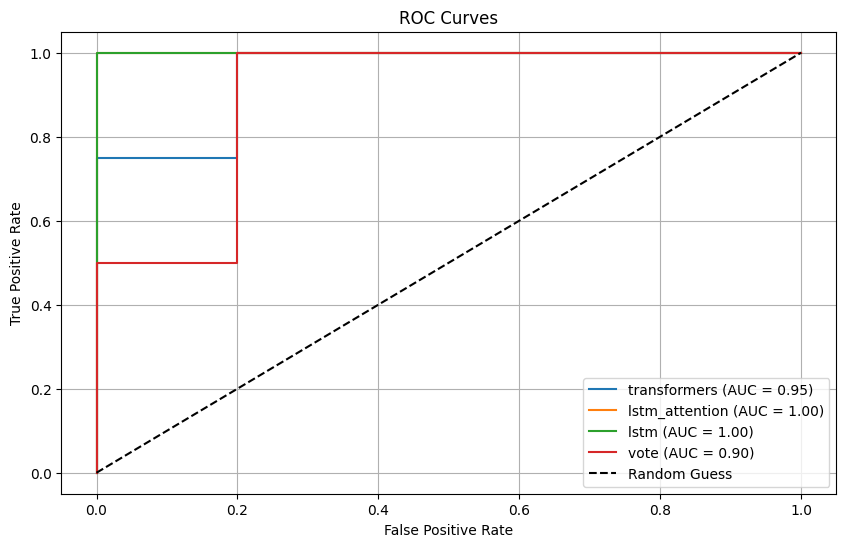

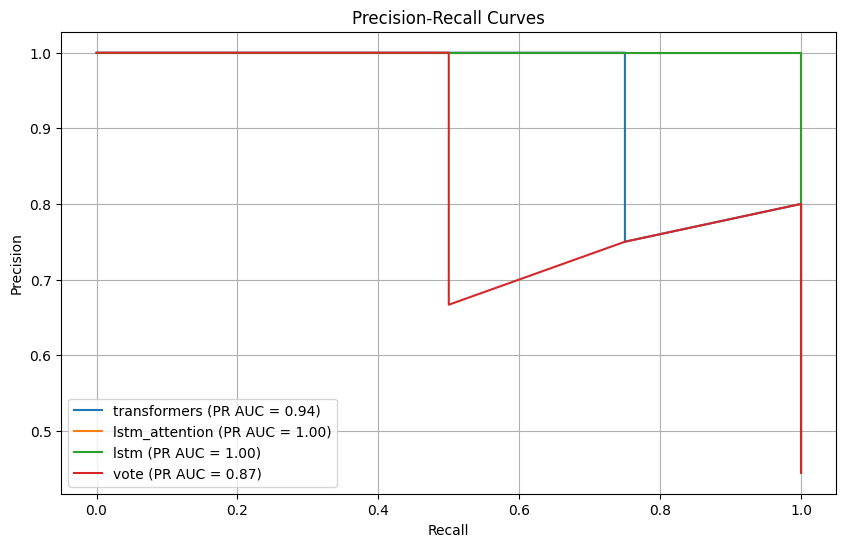

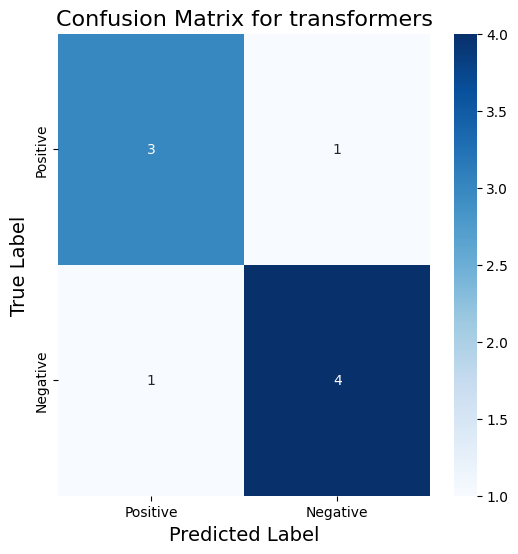

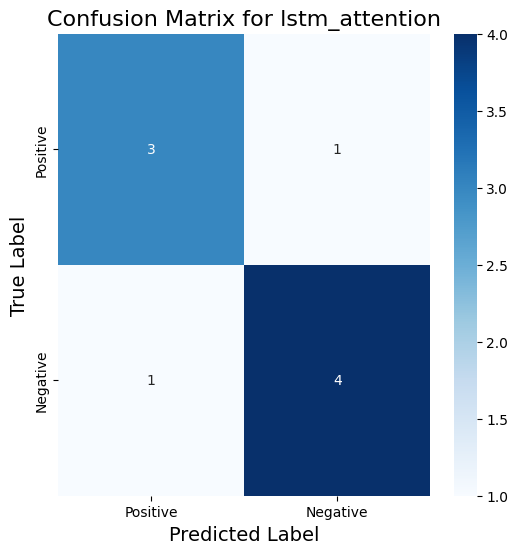

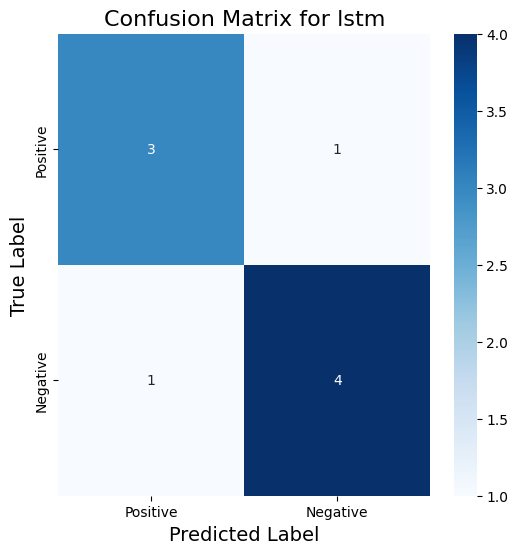

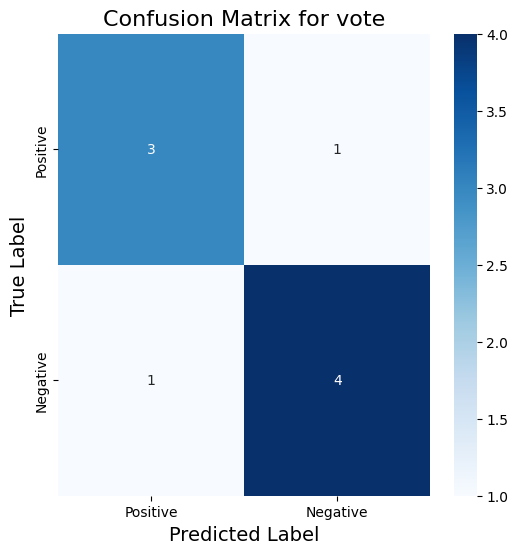

In [47]:
plt.figure(figsize=(10, 6))
for model_name, metrics in results.items():
    roc = metrics['roc']
    plt.plot(roc['fpr'], roc['tpr'], label=f"{model_name} (AUC = {roc['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for model_name, metrics in results.items():
    prc = metrics['prc']
    plt.plot(prc['recall'], prc['precision'], label=f"{model_name} (PR AUC = {prc['pr_auc']:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="lower left")
plt.grid()
plt.show()
    
for model_name, cm in results.items():
    cm = np.array(metrics['confusion_matrix'])
    reordered_cm = cm[[1, 0], :] 
    reordered_cm = reordered_cm[:, [1, 0]] 
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        reordered_cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=['Positive', 'Negative'],  
        yticklabels=['Positive', 'Negative'] )
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.show()